In [21]:
import pandas as pd 
import numpy as np 
from os import listdir as ls
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

In [25]:
#pre processing functions 
class OneHotEncoder:
    def __init__(self, categories):
        self.categories = categories
        self.category_to_index = {category: i for i, category in enumerate(categories)}
        self.num_categories = len(categories)

    def encode(self, category):
        if category not in self.category_to_index:
            raise ValueError(f"Category '{category}' not found in the provided categories.")
        else:
            encoded_vector = np.zeros(self.num_categories, dtype=np.float32)
            encoded_vector[self.category_to_index[category]] = 1
            return encoded_vector
            
def get_top_n_pers(seasons_pers, n): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in seasons_pers['season'].unique():
        subset = seasons_pers[seasons_pers['season'] == season]
        roster_pers[season] = {}
        for team in teams:
            team_subset = subset[subset['team_id'] ==  team]
            team_subset = team_subset.sort_values(by='per', ascending=False)
            roster_pers[season][team] = np.float32(team_subset['per'].iloc[:n]).flatten()
    return roster_pers

def get_p_stat(data, n, stat): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in data['season'].unique():
        subset = data[data['season'] == season]
        roster_pers[season] = {}
        for team in teams_roster:
            team_subset = subset[subset['Tm'] ==  team]
            team_subset = team_subset.sort_values(by=stat, ascending=False)
            roster_pers[season][team] = team_subset[stat].iloc[:n]
    return roster_pers
    
def get_season(season_string):
    cleaned_reg_season = season_reg.copy()
    columns = season_reg.columns
    date_features = ['date']
    string_features = [ 'home_team', 'away_team', 'arena']
    numeric_features = [ c for c in columns if c not in string_features + date_features]
    cleaned_reg_season[numeric_features] = cleaned_reg_season[numeric_features].apply(pd.to_numeric)
    cleaned_reg_season[date_features] = cleaned_reg_season[date_features].apply(pd.to_datetime)
    start_date, end_date = f'20{season_string[2:4]}-10',  f'20{season_string[-2:]}-05'
    season = cleaned_reg_season[(cleaned_reg_season["date"] >= start_date) & (cleaned_reg_season["date"] <= end_date)]
    return season
    
def get_past_season(season_name):
    start = int(season_name[0:4])-1
    end = int(season_name[-2:])-1
    prior_season_name = f'{start}-{end}'
    return prior_season_name

def get_team_avgs(season_name):
    prior_season_name = get_past_season(season_name)
    season = get_season(prior_season_name)
    # GET TEAM AVG OF THE WHOLE PAST SEASON 
    team_avg_p ={}
    home_stats_list  = ['home_team', 'home_fg', 'home_fga', 'home_fg_pct', 'home_fg3', 'home_fg3a', 'home_fg3_pct', 'home_ft', 'home_fta', 'home_ft_pct',
                        'home_orb', 'home_drb', 'home_trb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf']
    away_stats_list = ['away_team', 'away_fg', 'away_fga', 'away_fg_pct', 'away_fg3', 'away_fg3a', 'away_fg3_pct', 'away_ft', 'away_fta', 'away_ft_pct', 
                        'away_orb', 'away_drb', 'away_trb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts']
    count = {}
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        
        if home_stats[0] in team_avg_p.keys():
            team_avg_p[home_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] +=1
        else:
            team_avg_p[home_stats[0]] = home_stats[1:]   
            count[home_stats[0]] =1
        if away_stats[0] in team_avg_p.keys():
            team_avg_p[away_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] +=1
        else:
            team_avg_p[away_stats[0]] = away_stats[1:]
            count[away_stats[0]] =1
            
    for team in teams:
        team_avg_p[team] = [x / count[team] for x in team_avg_p[team]] 
        
    #GET ROLLING AVG FOR TEAMS USING EACH GAME OF CURRENT SEASON 
    season = get_season(season_name)
    count = {}
    home_pcol, away_pcol = [], []
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        #current season averages 
        if home_stats[0] not in count.keys():  
            home_pcol.append(team_avg_p[home_stats[0]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] = 2
        else:
            home_pcol.append([x/count[home_stats[0]] for x in team_avg_p[home_stats[0]]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]]+=1
        if away_stats[0] not in count.keys():  
            away_pcol.append(team_avg_p[away_stats[0]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] = 2
        else:
            away_pcol.append([x/count[away_stats[0]] for x in team_avg_p[away_stats[0]]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]]+=1
    home_pcol = [np.array(sublist) for sublist in home_pcol]
    away_pcol = [np.array(sublist) for sublist in away_pcol]
    return home_pcol, away_pcol 

In [32]:
def pre_process(season, top_n):
    season_name = season
    season = get_season(season)
    # shuffles data
    # season  = season.sample().reset_index(drop=True)
    alt_season = season.copy(deep=True)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    nc_home, nc_away = get_team_avgs(season_name)
    # get one hot encodings and player stats 
    home_team, home_pers = [], []
    away_team, away_pers = [], []
    arena, winner = [], []
    row_stats = {}
    for stat in list(player_stats.keys()):
        row_stats["home_"+stat+"_input"] = []
        row_stats["away_"+stat+"_input"] = []

    for index, row in alt_season.iterrows():       
        home_team.append(team_encoder.encode(row.iloc[0]))
        away_team.append(team_encoder.encode(row.iloc[1]))
        arena.append(arena_encoder.encode(row.iloc[2]))
        winner.append(team_encoder.encode(row.iloc[3]))
        # get top n player stats
        if season_name == '2014-15':
            raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
        else: 
            prior_season_name = get_past_season(season_name)
        home_pers.append(rosters[prior_season_name][row.iloc[0]])
        away_pers.append(rosters[prior_season_name][row.iloc[1]])
        for stat in list(player_stats.keys()):
            row_stats["home_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[0]])
            row_stats["away_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[1]])
    # add non player stat data
    row_stats["home_pers_input"] = home_pers
    row_stats["away_pers_input"] = away_pers
    row_stats["home_team_input"] = home_team
    row_stats["away_team_input"] = away_team
    row_stats["home_avg_stats_input"] = nc_home
    row_stats["away_avg_stats_input"] = nc_away
    row_stats["arena_input"] = arena

    #convert to tensors 
    for item in row_stats.keys():
        row_stats[item] = tf.convert_to_tensor(row_stats[item])
        
    return row_stats,  {"spread": spread, "outcome": tf.convert_to_tensor(winner)}

In [46]:
def build_model(x_dict, y_dict, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_list = []
    l1 = 0 
    for input in inputs:
        var_name = f"{input}" 
        var_name = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        input_list.append(var_name)
        l1+=x_dict[input].shape[1]
        
    concatenated_inputs = tf.keras.layers.concatenate(input_list)
    activeFunc = 'gelu'
    layers = [l1]+layers
    last_h_layer = None
    for i in range(len(layers)):
        var_name = f"h_{i}"
        units = layers[i]
        if i==0:
            prev_layer = tf.keras.layers.Dense(l1, activation=activeFunc)(concatenated_inputs)
        elif i == len(layers)-1:
            last_h_layer = tf.keras.layers.Dense(units, activation=activeFunc)(prev_layer)
        else:
            prev_layer = tf.keras.layers.Dense(units, activation=activeFunc)(prev_layer)
    
    concatenated_teams = tf.keras.layers.concatenate([input_list[0], last_h_layer,input_list[-1]])
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(last_h_layer)
    output_outcome = tf.keras.layers.Dense(30, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=input_list, outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':categorical_crossentropy}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

In [42]:
season_reg = pd.read_csv('season_reg.csv') #2014-15 - 2022-23 regular_season matches 
seasons_pers = pd.read_csv('seasons_per_s.csv') #2014-15 - 2022-23 player eficiency ratings

# procesing advanced player stats data
# adv_stats= pd.read_csv("advanced_stats_15-23.csv")
# adv_stats= adv_stats.drop(['Unnamed: 0', 'Unnamed: 19', 'Unnamed: 24', 'Rk'], axis = 1)
# team_season = adv_stats[['Tm', "season"]]
# adv_stats= adv_stats.select_dtypes(include='number')
# adv_stats[['Tm', "season"]]= team_season
# adv_stats_processed = adv_stats
# adv_stats_processed
# adv_stats_processed.to_csv("adv_stats_data.csv")
adv_stats = pd.read_csv("adv_stats_data.csv")
adv_stats = adv_stats.drop(['Unnamed: 0'], axis = 1)
adv_stats.rename(columns={'WS/48': 'win_shares_48'}, inplace=True)

In [50]:
teams = season_reg['home_team'].unique()
arenas = season_reg['arena'].unique()
teams_roster = adv_stats["Tm"].unique()
team_encoder = OneHotEncoder(teams)
arena_encoder = OneHotEncoder(arenas)
rosters = get_top_n_pers(seasons_pers, 8)  # rosters[season][team]

player_stats ={}

for stat in adv_stats:
    # create variable for top stat dict
    if stat != 'Tm' and stat != 'season':
        player_stats[stat] = get_p_stat(adv_stats, 8, stat)
    
# rosters_obpm = get_p_stat(adv_stats, 8, "OBPM")  # rosters[season][team]
# rosters_dbpm = get_p_stat(adv_stats, 8, "DBPM")


In [68]:
x_2016, y_2016= pre_process('2015-16', top_n=8)
x_2017, y_2017= pre_process('2016-17',top_n=8)

In [82]:
home_keys = [key for key in x_2016 if 'home' in key]
keys_with_home = [key for key in home_keys  if key != 'home_team_input' and key != 'home_avg_stats_input']

In [73]:
model = build_model(x_2016, y_2016, model_name ="model_all", layers =[529, 529, 529, 529], show_summary = False)
history = model.fit(x=x_2016, y=y_2016, epochs=50, batch_size=150, validation_split = 0.3, verbose = 0)
print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")

#evaluating on loss
# print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")

Best loss = 148.7407684326172, Best validation_loss = 166.14854431152344
Best accuracy = 0.3182346224784851, Best validation_accuracy = 0.2926829159259796


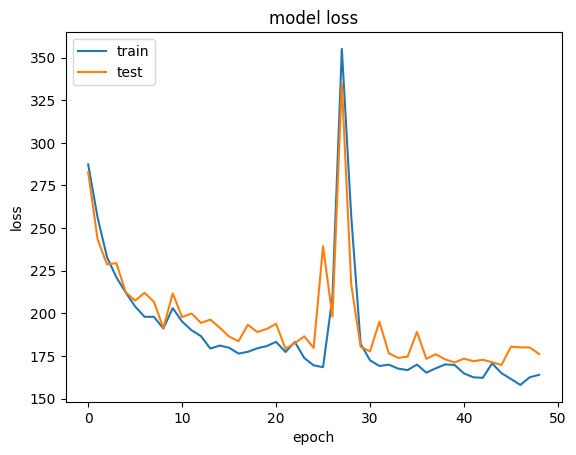

In [69]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()